In [67]:
from pathlib import Path
import torch
import pandas as pd
from tifffile import tifffile
import numpy as np
from dotenv import dotenv_values

In [68]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [69]:
config = dotenv_values()

In [70]:
import sys
sys.path.insert(0, "../../cellamander/src/cellamander/")
from cellamander import Cellamander, CellamanderRecipe

In [11]:
torch_device = torch.device("cpu")
model_path = config['MODEL_PATH']
image1 = tifffile.imread("../../multid-cellpose/training/DD_les_pos10/DD_les_pos10_CD3-blue_CD4-green_CD8-red_CD11c-yellow_CD45_noedge-gray_224x224.tif")
image2 = tifffile.imread("../../multid-cellpose/training/DD_les_pos17/DD_les_pos17_CD3-blue_CD4-green_CD8-red_CD11c-yellow_CD45_noedge-gray_224x224.tif")
images = np.array([np.moveaxis(image1, 0, -1)])
images.shape

(1, 224, 224, 5)

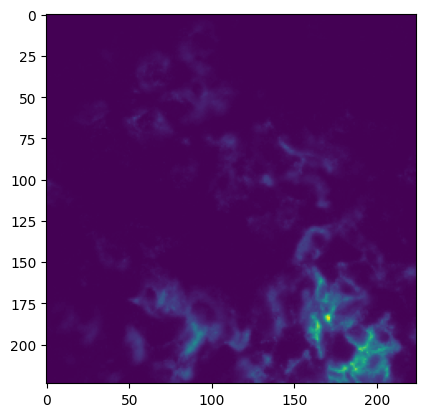

In [21]:
import matplotlib.pyplot as plt
plt.imshow(images[0,...,4])

In [71]:
cs = Cellamander(gpu=False, pretrained_model=model_path, device=torch_device)

/Users/ldipeso/Documents/Zhu-Lab/cellamander/.venv/lib/python3.12/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

In [16]:
root_dir = Path(config['GT_PATH'])
cd4_roi_path = root_dir / "CD3gt_phenotyping/DD_les_CD3gt_CD3+CD4+_RoiSet_85/"
cd4_roi_files = [ x for x in cd4_roi_path.glob("*.roi") if x.name[0] != "." ]

In [22]:
# Channels for this image are:
# 0: CD8a
# 1: CD4
# 2: CD3
# 3: CD45
# 4: CD11c

In [81]:
gt_df, pred_df, weights = cs.find_recipes(
    images, 
    [cd4_roi_files], 
    required_channels=[1,2], 
    absent_channels=[4], 
    ignore_dP_channels=[3],
    ignore_cellprob_channels=[0,3],
    flow_threshold=0.7,
    step_size=0.5,
    fix_dPs=[0.0,None,None,0.0]
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [18:57<00:00,  7.90s/it]


In [82]:
weights

,dP_0,dP_1,dP_2,dP_3,dP_4,cellprob_0,cellprob_1,cellprob_2,cellprob_3,cellprob_4
0,0.0,0.5,0.5,0.0,-1.0,0.0,0.5,0.5,0.0,-1.0
1,0.0,1.0,0.5,0.0,-1.0,0.0,0.5,0.5,0.0,-1.0
2,0.0,0.5,1.0,0.0,-1.0,0.0,0.5,0.5,0.0,-1.0
3,0.0,1.0,1.0,0.0,-1.0,0.0,0.5,0.5,0.0,-1.0
4,0.0,0.5,0.5,0.0,-0.5,0.0,0.5,0.5,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
139,0.0,1.0,1.0,0.0,-0.5,0.0,1.0,1.0,0.0,0.0
140,0.0,0.5,0.5,0.0,0.0,0.0,1.0,1.0,0.0,0.0
141,0.0,1.0,0.5,0.0,0.0,0.0,1.0,1.0,0.0,0.0
142,0.0,0.5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [83]:
gt_df.sort_values("ap_50")

,image_id,recipe_id,iou,miou,miou_tp_50,tp_50,fp_50,fn_50,ap_50
0,0,50,0.217324,0.136981,0.686883,8,1,77,0.093023
0,0,42,0.218099,0.136488,0.675777,8,1,77,0.093023
0,0,82,0.204497,0.123510,0.642831,8,1,77,0.093023
0,0,54,0.218099,0.136488,0.675777,8,1,77,0.093023
0,0,46,0.221629,0.138156,0.682263,8,1,77,0.093023
...,...,...,...,...,...,...,...,...,...
0,0,112,0.637765,0.404634,0.720466,31,1,54,0.360465
0,0,115,0.632754,0.401276,0.725578,31,1,54,0.360465
0,0,118,0.614618,0.400267,0.703353,32,1,53,0.372093
0,0,116,0.647120,0.408759,0.719997,33,3,52,0.375000


In [84]:
weights.iloc[gt_df.loc[gt_df.ap_50 == 0.375000, 'recipe_id']]

,dP_0,dP_1,dP_2,dP_3,dP_4,cellprob_0,cellprob_1,cellprob_2,cellprob_3,cellprob_4
116,0.0,0.5,0.5,0.0,0.0,0.0,1.0,0.5,0.0,0.0
119,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0


In [148]:
# Best recipes are functionally identical:
cd4_recipe = CellamanderRecipe({
    'meta': {'name': 'CD4 T-cells'},
    'data': [
        {'dP': 0.0, 'cellprob': 0.0 },
        {'dP': 1.0, 'cellprob': 1.0 },
        {'dP': 1.0, 'cellprob': 0.5 },
        {'dP': 0.0, 'cellprob': 0.0 },
        {'dP': 0.0, 'cellprob': 0.0 }
    ]
})

cd8_recipe = CellamanderRecipe({
    'meta': {'name': 'CD8a T-cells'},
    'data': [
        {'dP': 1.0, 'cellprob': 1.0 },
        {'dP': 0.0, 'cellprob': 0.0 },
        {'dP': 0.0, 'cellprob': 0.0 },
        {'dP': 0.0, 'cellprob': 0.0 },
        {'dP': 0.0, 'cellprob': 0.0 }
    ]
})

In [150]:
masks, flows = cs.mander(images, [ cd4_recipe, cd8_recipe ], flow_threshold=0.7)

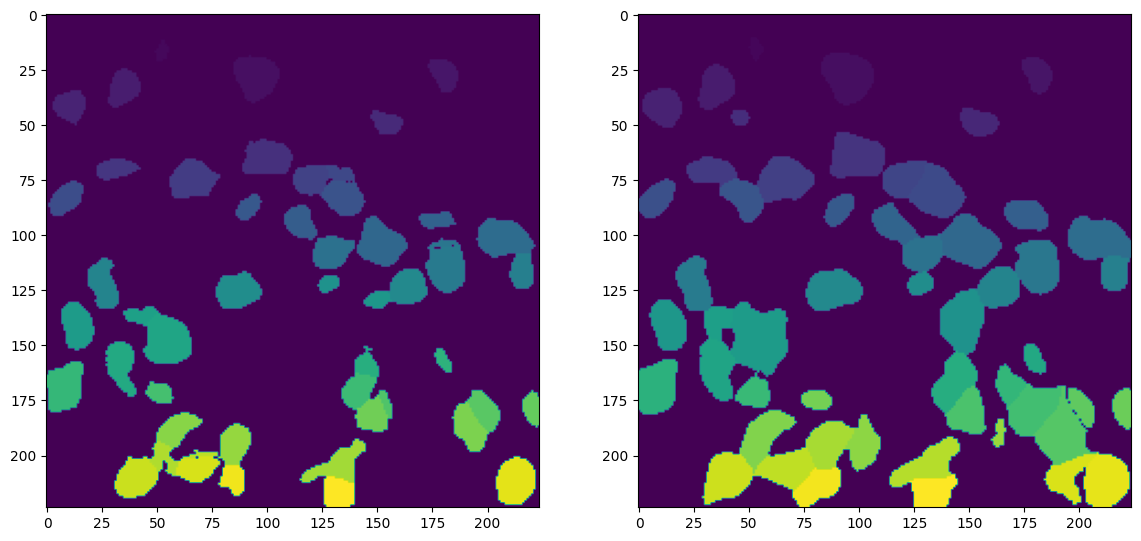

In [157]:
# Compare with standard cellpose
cp_masks, _, _ = cs._model.eval(images[0,...,1], channels=[0,0], flow_threshold=0.7)
f,ax = plt.subplots(1,2, figsize=(14,10))
ax[0].imshow(masks[0]['CD4 T-cells'])
ax[1].imshow(cp_masks)

Text(0.5, 0.98, 'Ground truth in red, prediction in blue')

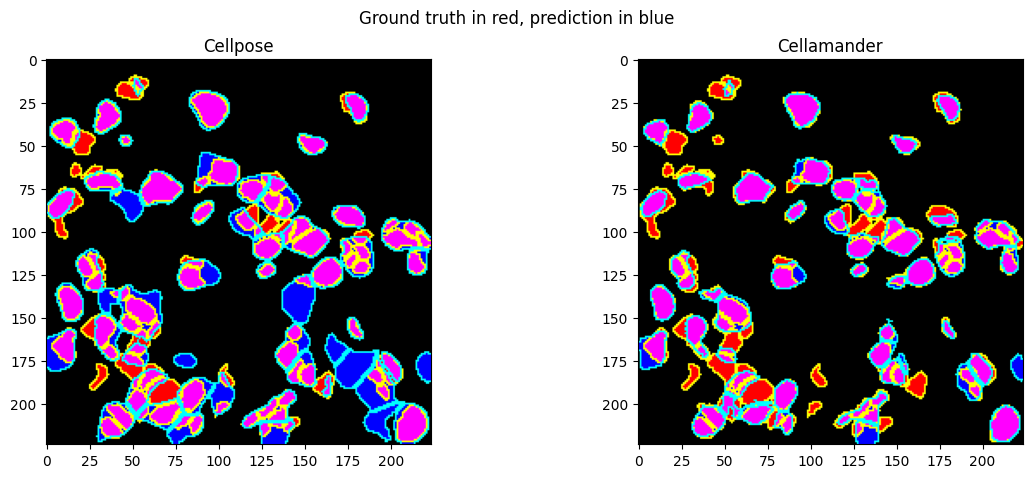

In [171]:
from skimage.segmentation import find_boundaries
from roifile import ImagejRoi
import cv2

gt_masks = np.zeros(( comp_masks.shape[0], comp_masks.shape[1] ), dtype=np.uint16)
for i,roi_file in enumerate(cd4_roi_files):
    roi = ImagejRoi.fromfile(roi_file)
    vertices = np.expand_dims(roi.coordinates(), axis=1).astype(np.int32)
    label = cv2.fillPoly(np.zeros(( comp_masks.shape[0], comp_masks.shape[1] ), dtype=np.uint8), [vertices], 1)
    gt_masks[label > 0] = i+1
# plt.imshow(gt_masks)

comp = np.zeros(( gt_masks.shape[0], gt_masks.shape[1], 3), dtype=np.uint8)
orig = np.zeros_like(comp)

comp[gt_masks > 0] = [255, 0, 0]
orig[gt_masks > 0] = [255, 0, 0]

comp[masks[0]['CD4 T-cells'] > 0] = [0, 0, 255]
orig[cp_masks > 0] = [0, 0, 255]

comp[(gt_masks > 0) & (masks[0]['CD4 T-cells'] > 0)] = [255, 0, 255]
orig[(gt_masks > 0) & (cp_masks > 0)] = [255, 0, 255]

comp[find_boundaries(gt_masks, connectivity=2, mode='inner')] = [255,255,0]
orig[find_boundaries(gt_masks, connectivity=2, mode='inner')] = [255,255,0]

comp[find_boundaries(masks[0]['CD4 T-cells'], connectivity=2, mode='inner')] = [0,255,255]
orig[find_boundaries(cp_masks, connectivity=2, mode='inner')] = [0,255,255]

f, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].imshow(orig)
ax[1].imshow(comp)
ax[0].title.set_text("Cellpose")
ax[1].title.set_text("Cellamander")
f.suptitle("Ground truth in red, prediction in blue")

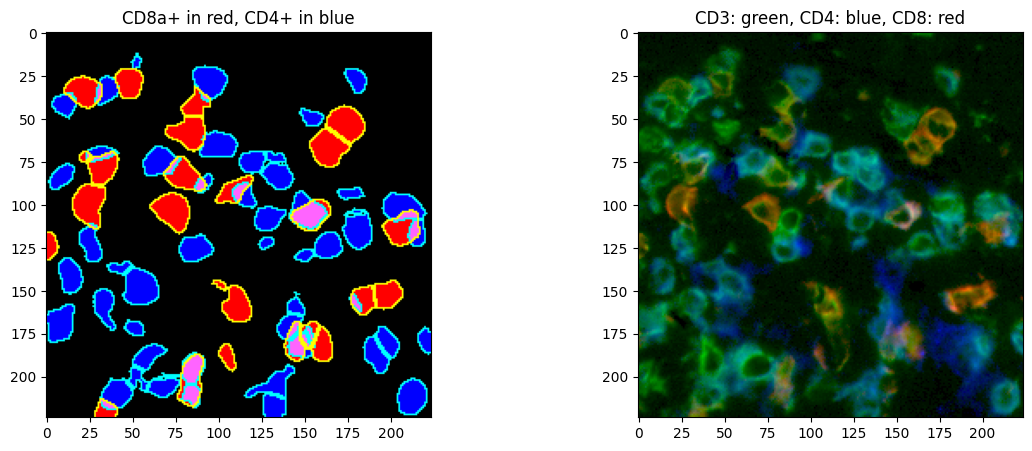

In [186]:
from skimage.exposure import rescale_intensity, adjust_gamma

overlap = np.zeros(( gt_masks.shape[0], gt_masks.shape[1], 3), dtype=np.uint8)

overlap[masks[0]['CD4 T-cells'] > 0,2] = 255
overlap[masks[0]['CD8a T-cells'] > 0,0] = 255
overlap[(overlap[...,0] == 255) & (overlap[...,2] == 255),1] = 100

overlap[find_boundaries(masks[0]['CD4 T-cells'], connectivity=2, mode='inner')] = [0,255,255]
overlap[find_boundaries(masks[0]['CD8a T-cells'], connectivity=2, mode='inner')] = [255,255,0]

f, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].imshow(overlap)
ax[1].imshow(adjust_gamma(rescale_intensity(
    np.stack([ images[0,...,0], images[0,...,2], images[0,...,1] ], axis=-1)
), 0.5))
ax[0].title.set_text("CD8a+ in red, CD4+ in blue")
ax[1].title.set_text("CD3: green, CD4: blue, CD8: red")